# Chapter 14: Knowledge Retrieval (RAG)

LLM은 사람과 유사한 텍스트를 생성하는 데 상당한 역량을 보인다. 그러나 LLM의 지식 기반은 일반적으로 학습에 사용된 데이터로 제한되기 때문에, 실시간 정보나 특정 기업의 내부 데이터, 혹은 고도로 특수화된 세부 정보에는 접근하기 어렵습니다.  

RAG는 LLM이 외부에 존재하는 최신의, 맥락에 특화된 정보를 조회하고 통합해, 모델이 생성하는 결과의 정확성·관련성·사실 기반을 강화한다.  

정적인 학습 데이터에만 의존하지 않고 실시간으로 검증 가능한 외부 데이터에 근거해 자신의 행동과 응답을 설계할 수 있게 해 주기 때문에 AI 에이전트에게 특히 중요하다. 이 능력으로 에이전트는 특정 질문에 답하기 위해 최신 사내 정책을 조회하거나, 주문을 넣기 전에 현재 재고를 확인하는 등 복잡한 작업도 정확하게 수행할 수 있다.  

RAG는 외부 지식을 통합함으로써 에이전트를 단순한 대화 상대에서 벗어나, 실제로 의미 있는 업무를 수행할 수 있는 효과적인 데이터 기반 도구로 변화시킨다.

## 지식 검색(RAG) 패턴 개요

RAG를 사용하면 모델이 자신의 내부 사전 학습 지식에만 의존하는 대신, 사람이 책을 찾아보거나 인터넷 검색을 하듯이 정보를 “조회(look up)”할 수 있다. 이 과정으로 LLM은 더 정확하고, 최신이며, 검증 가능한 답변을 제공할 수 있다.

사용자가 RAG를 사용하는 AI 시스템에 질문을 하거나 프롬프트를 입력하면, 이 쿼리는 곧바로 LLM에 전달되지 않는 대신 시스템은 먼저 방대한 외부 지식 베이스—잘 조직된 문서, 데이터베이스, 웹 페이지 등의 라이브러리—를 탐색하여 관련 정보를 찾는다.     
이 검색은 단순한 키워드 매칭이 아니라, 사용자의 의도와 표현의 의미를 이해하는 **“시맨틱 검색(semantic search)”**이다.   
이 1차 검색 단계에서 가장 관련성이 높은 스니펫이나 “청크(chunk)”들이 추출된다.

이렇게 추출된 정보 조각들은 원래 프롬프트에 덧붙여져(**“증강(augmented)”**) 더 풍부하고 정보가 보강된 쿼리를 만들고, 이 확장된 프롬프트가 LLM에 전달된다. LLM은 이 추가 컨텍스트를 바탕으로, 자연스럽고 유창할 뿐만 아니라 **검색된 데이터에 사실적으로 기반한 응답**을 생성할 수 있게 된다.

RAG 프레임워크는 여러 가지 장점이 있다. 먼저, LLM이 **최신 정보에 접근**할 수 있게 하여 정적인 학습 데이터만 가지고 있을 때의 한계를 극복한다. 또한, 검증 가능한 데이터에 기반해 응답을 생성하도록 만들어, 잘못된 정보를 만들어내는 **“할루시네이션(hallucination)”** 위험을 줄여 준다. 더불어, 회사 내부 문서나 위키 등에 담긴 **특수한 도메인 지식**도 활용할 수 있다.

또 다른 중요한 장점은, 정보의 정확한 출처를 가리키는 “출처 표기(citations)”를 제공할 수 있다.

RAG가 어떻게 동작하는지 제대로 이해하려면 몇 가지 핵심 개념을 알아둘 필요가 있습니다

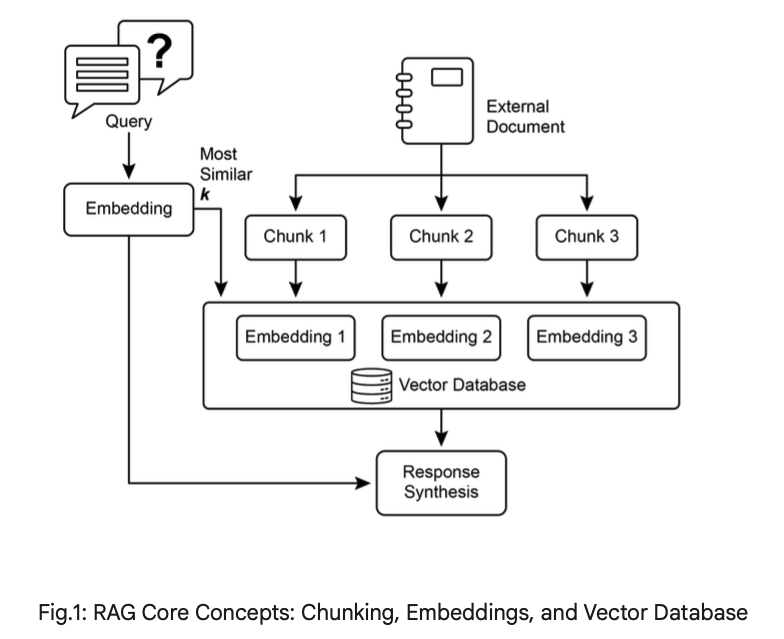


### 임베딩(Embeddings)

LLM 문맥에서 **임베딩(embedding)**은 단어, 구, 문서 전체 같은 텍스트를 숫자로 표현한 값으로 **벡터(vector)**라고 불리며, 숫자들의 리스트 형태다. 핵심 아이디어는 **텍스트의 의미와 서로 간의 관계를 수학적 공간에 담는 것**이다.

- 의미가 비슷한 단어/구는 벡터 공간에서 서로 **가까운 위치**에 놓입니다.
- 예를 들어, 아주 단순한 2차원 좌표 평면을 떠올려 보면:
  - `"cat"`은 (2, 3)
  - `"kitten"`은 (2.1, 3.1)처럼 아주 가까운 위치  
  - `"car"`는 (8, 1)처럼 훨씬 떨어진 위치  
  로 표현될 수 있습니다.

실제 임베딩은 이렇게 단순한 2차원이 아니라, **수백~수천 차원의 고차원 공간**에 존재한다. 덕분에 언어의 미묘한 의미와 관계까지도 비교적 정교하게 표현할 수 있다.

---

### 텍스트 유사도(Text Similarity)

**텍스트 유사도**는 두 텍스트가 **얼마나 비슷한지**를 측정하는 개념.

- 단순히 단어 겹침을 보는 **어휘적 유사도(lexical similarity)** 수준일 수도 있고,
- 더 깊게 의미와 문맥을 고려하는 수준일 수도 있다.

RAG에서는, **사용자의 질의와 지식 베이스에 들어 있는 텍스트 중 어떤 것이 가장 관련이 높은지 찾는 것**이 매우 중요하기 때문에 텍스트 유사도가 핵심이다.

예를 들어:
- `"What is the capital of France?"`
- `"Which city is the capital of France?"`  

두 문장은 표현은 다르지만, 사실상 같은 질문이다.  
좋은 텍스트 유사도 모델은 이 둘에 **높은 유사도 점수**를 주며, 겹치는 단어는 적더라도 **의미가 같다는 것**을 인식한다.  
이 유사도는 보통 각 문장의 **임베딩을 이용해 계산**한다.

---

### 의미적 유사도와 거리  
(Semantic Similarity and Distance)

**의미적 유사도(semantic similarity)**는 텍스트 유사도 중에서도 특히 **“의미와 문맥”**에 초점을 맞춘 개념.  
단어 겹침이 아니라, **같은 개념/아이디어를 말하고 있는지**를 보고 판단.

- 의미적 유사도가 높을수록 **의미적 거리(semantic distance)**는 낮고,
- 의미적 유사도가 낮을수록 의미적 거리는 높습니다.

RAG의 **시맨틱 검색(semantic search)**은 사용자의 질의와 **의미적 거리가 가장 작은 문서**를 찾는 과정이다.

예를 들어:
- `"a furry feline companion"`
- `"a domestic cat"`  

이 두 표현은 `"a"` 하나를 제외하면 공통 단어가 없다. 그러나 의미를 이해하는 모델이라면 이 둘이 **같은 대상을 가리킨다**는 점을 알아차리고, **매우 높은 의미적 유사도**를 부여한다.  
이는 두 표현의 임베딩이 벡터 공간에서 **서로 매우 가까운 위치**에 있기 때문이다.  
이런 “스마트 검색” 덕분에, 사용자의 말이 지식 베이스 문서의 문장과 똑같이 일치하지 않아도 RAG는 관련 있는 정보를 찾아낼 수 있다.

---

### 문서 청킹(Chunking of Documents)

**청킹(chunking)**은 큰 문서를 더 작고 다루기 쉬운 조각(청크)으로 나누는 과정.

RAG 시스템은 거대한 문서를 통째로 LLM에 넣을 수 없다. 대신:

1. 문서를 적절한 단위로 잘게 나누고,
2. 작은 청크 단위로 처리

청킹 전략은 **문맥과 의미를 잘 보존하는 방식**이어야 한다.

예시:
- 50페이지짜리 사용자 매뉴얼을 하나의 긴 텍스트로 다루는 대신,
  - 섹션 단위
  - 문단 단위
  - 혹은 문장 단위
  로 나눌 수 있다.
- 예를 들어 `"Troubleshooting"` 섹션은 `"Installation Guide"`와는 **별도의 청크**로 다루어진다.

사용자가 특정 문제에 대해 질문하면, RAG 시스템은 전체 매뉴얼이 아니라 **가장 관련 있는 문제 해결(Troubleshooting) 청크만** 가져온다.  
이렇게 하면:

- 검색 속도가 빨라지고,
- LLM에 전달되는 정보가 **사용자의 현재 질문에 더 집중된, 관련성 높은 내용**이 된다.

문서를 청킹한 뒤에는, RAG 시스템이 **어떤 청크가 질의에 가장 관련이 있는지 찾기 위한 검색 기법**을 사용해야 한다.

#### 주요 검색 기법

1. **벡터 검색(Vector Search)**  
   - 임베딩과 의미적 거리를 사용해,  
     사용자 질문과 **개념적으로 가장 가까운 청크**를 찾는다.

2. **BM25 (전통적인 키워드 기반 알고리즘)**  
   - 오래된 방식이지만 여전히 유용한 기법.
   - 단어의 등장 빈도 등을 이용해 청크를 랭킹.
   - 다만 **의미를 이해하는 능력은 없고**, 키워드 매칭 중심.

3. **하이브리드 검색(Hybrid Search)**  
   - 벡터 검색의 **문맥·의미 이해 능력**과  
   - BM25의 **키워드 정확도**를 결합.
   - 문자 그대로의 매칭과 개념적 관련성을 동시에 잡기 때문에  
     **더 견고하고 정확한 검색 결과**를 제공.

---

### 5. 벡터 데이터베이스(Vector Databases)

**벡터 데이터베이스(vector database)**는 임베딩을 효율적으로 저장하고 조회하기 위해 설계된 **특수한 데이터베이스**.

- 문서가 청킹되고 임베딩으로 변환되면,
- 이 고차원 벡터들이 벡터 데이터베이스에 저장됨.

전통적인 키워드 기반 검색은:

- 질의에 포함된 단어와 일치하는 문서를 찾는 데는 매우 뛰어나지만,
- 언어의 깊은 의미를 이해하지는 못한다.
- 예를 들어 `"furry feline companion"`이 `"cat"`을 의미한다는 것을 스스로 알기 어렵다.

반면, 벡터 데이터베이스는 **시맨틱 검색에 최적화**되어 있다.

- 텍스트를 숫자 벡터로 저장해,  
  **단어가 아니라 의미를 기준으로 검색**한다.
- 사용자의 질의도 임베딩(벡터)으로 변환한 뒤,
  - HNSW(Hierarchical Navigable Small World) 같은 고성능 알고리즘으로
  - 수백만 개 벡터 중에서 **의미적으로 가장 “가까운” 것들**을 빠르게 찾아낸다.

이 방식은,  
사용자의 표현이 원문과 완전히 달라도 **관련 있는 문맥을 찾아낼 수 있기 때문에**, RAG에 특히 뛰어난 성능을 제공한다.

> 정리하자면,  
> 전통적인 검색은 **“단어”를 찾고**,  
> 벡터 데이터베이스는 **“의미”를 찾는다.**

#### 구현 예시

벡터 데이터베이스 기술은 다양한 형태로 구현된다.

- 매니지드 서비스:
  - Pinecone
  - Weaviate
- 오픈소스 솔루션:
  - Chroma DB
  - Milvus
  - Qdrant
- 기존 데이터베이스에 벡터 기능을 확장한 형태:
  - Redis
  - Elasticsearch
  - Postgres + `pgvector` 확장

이들 시스템의 코어 검색 기능은 보통:

- Meta AI의 **FAISS**,
- Google Research의 **ScaNN**

같은 라이브러리가 뒷받침하며,  
이들이 벡터 검색의 효율성을 책임지는 핵심 엔진 역할을 한다.

### RAG의 과제(Challenges)

강력함에도 불구하고, RAG 패턴에는 여러 가지 **도전 과제**가 존재한다.  
가장 대표적인 문제는, 어떤 질의에 답하는 데 필요한 정보가 **하나의 청크에만 들어 있지 않고** 문서의 여러 부분이나 심지어 여러 문서에 걸쳐 흩어져 있을 때 발생한다.  

이런 경우, 리트리버가 필요한 모든 컨텍스트를 한 번에 모으는 데 실패할 수 있고, 그 결과 **불완전하거나 부정확한 답변**이 생성될 수 있다.

또한 시스템의 효과는 **청킹 전략과 검색(리트리벌) 품질**에 크게 의존한다.  
만약 **관련성이 낮은 청크**가 검색되면, 그 노이즈가 LLM을 혼란스럽게 만들어 응답 품질을 떨어뜨릴 수 있습니다.  
여기에 더해, 서로 **모순될 수도 있는 여러 출처의 정보**를 효과적으로 통합·종합하는 것 역시 여전히 어려운 문제다.

---

또 다른 도전 과제는

RAG를 사용하려면 **전체 지식 베이스를 사전에 전처리**하고  
벡터 데이터베이스나 그래프 데이터베이스 같은 **특수한 저장소에 넣어 두어야 한다**는 점.  
상당한 공수가 드는 일입니다.

게다가 이렇게 저장된 지식은 **주기적으로 동기화/갱신(reconciliation)**해야 최신 상태를 유지할 수 있다.  
특히 사내 위키처럼 내용이 자주 바뀌는 소스를 다루는 경우에는 더욱 중요합니다.  

이 모든 과정은 시스템 성능에도 영향을 미쳐:

- 지연 시간(latency) 증가  
- 운영 비용 상승  
- 최종 프롬프트에 사용되는 토큰 수 증가  

등의 부작용을 낳을 수 있습니다.

---

정리하자면, **Retrieval-Augmented Generation(RAG)** 패턴은  
AI를 더 **지식 풍부하고 신뢰할 수 있는 시스템**으로 만드는 데 있어 매우 큰 진보를 이룹니다.

- RAG는 **생성 전에 외부 지식 검색 단계를 끼워 넣는 방식**으로,  
  독립형 LLM이 갖는 핵심 한계(정적인 학습 데이터, 최신 정보 부족 등)를 보완합니다.
- 임베딩과 의미적 유사도(semantic similarity) 같은 **기초 개념** 위에,  
  키워드 검색과 하이브리드 검색 같은 **검색 기법**을 결합하여  
  시스템이 **관련 있는 정보를 지능적으로 찾아낼 수 있도록** 합니다.
- 이렇게 검색된 정보는 전략적인 **청킹(chunking)**을 통해  
  LLM이 다루기 적합한 단위로 관리됩니다.
- 이 전체 검색 과정은, 수백만 개의 임베딩을 **대규모로 저장·조회할 수 있도록 설계된 벡터 데이터베이스**가 뒷받침합니다.

물론, **흩어져 있거나 서로 상충하는 정보**를 완벽하게 처리하는 문제는 여전히 해결해야 할 과제로 남아 있습니다.  
그럼에도 RAG는, LLM이 단지 문맥에 맞는 자연스러운 말만 하는 것이 아니라,  
**검증 가능한 사실에 기반을 둔 응답**을 생성하도록 도와 줌으로써  
AI에 대한 **신뢰성과 실용성**을 크게 높여 줍니다.

## Graph RAG

**GraphRAG**는 정보 검색에 단순한 벡터 데이터베이스 대신 **지식 그래프(knowledge graph)**를 사용하는 고급 형태의 RAG(Retrieval-Augmented Generation).  
이 방식은 구조화된 지식 베이스 안에서 **데이터 엔티티(노드)들 사이의 명시적인 관계(엣지)**를 따라가며 복잡한 질의를 해결한다.

GraphRAG의 핵심 장점은, 전통적인 RAG가 자주 실패하는 지점인  
**여러 문서에 흩어져 있는 조각난 정보들을 종합해서 하나의 답으로 만들어낼 수 있다**는 점이다.  
관계 구조를 이해함으로써, GraphRAG는 **맥락적으로 더 정확하고 미묘한 차이까지 반영된 응답**을 제공할 수 있다.

### 활용 사례

GraphRAG는 특히 다음과 같은 **복잡한 연결 관계를 다루는 영역**에서 유용합니다.

- 복잡한 **재무 분석**  
- 개별 **기업과 시장 이벤트**를 연결해 분석하는 작업  
- **유전자와 질병 사이의 관계**를 탐색하는 과학 연구  

### 한계와 단점

그러나 주요 단점도 분명합니다.

- 고품질의 지식 그래프를 **구축하고 유지**하기 위해  
  상당한 **복잡도, 비용, 전문성**이 요구됩니다.
- 구조가 고정적이어서 **유연성이 낮을 수 있고**,  
  단순 벡터 검색 시스템보다 **지연 시간(latency)**이 더 길어질 수 있다.
- 시스템의 성능은 전적으로 **그래프 구조의 품질과 완전성**에 의존한다.

### 요약

결국 GraphRAG는:

- **복잡하고 얽힌 질문에 대해 더 뛰어난 맥락 추론 능력**을 제공하지만,  
- 그 대가로 **매우 높은 구현 및 유지보수 비용**을 요구하는 방식이다.

즉, **속도와 단순성**이 중요한 일반적인 RAG 상황보다는,  
**깊게 연결된 인사이트**가 훨씬 더 중요한 문제에서 진가를 발휘하는 접근 방식이다.

## Agentic RAG

**Agentic RAG**는 기존 RAG 패턴이 한 단계 진화한 형태로,  
**추론(reasoning)**과 **의사결정(decision-making)** 레이어를 도입하여 정보 추출의 신뢰성을 크게 높이는 접근이다.

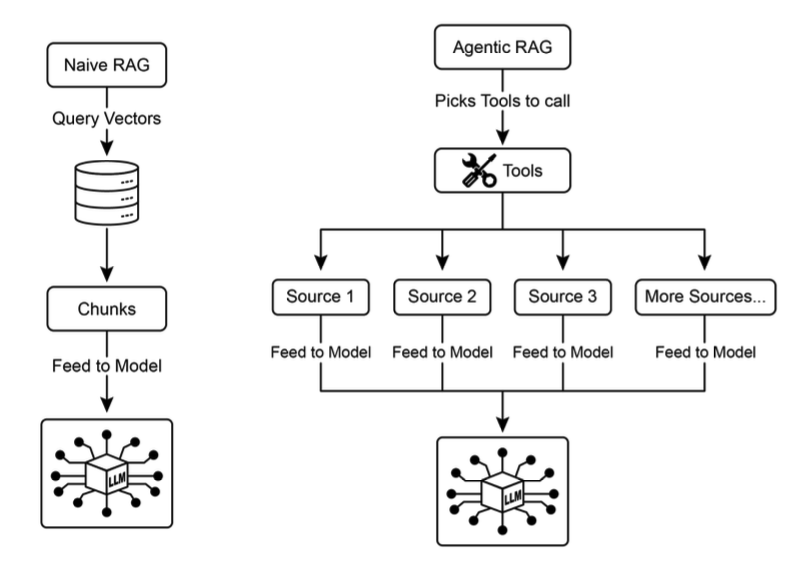

기존 RAG가 단순히 “검색하고( retrieve ) 프롬프트를 증강( augment )”하는 데 그쳤다면,  
Agentic RAG에서는 **“에이전트(agent)”**라는 특수화된 AI 컴포넌트가  
지식에 대한 **중요한 게이트키퍼이자 정제기(refiner)** 역할을 수행한다.

즉, 처음 검색된 데이터를 수동적으로 그대로 받아들이는 것이 아니라,  
이 에이전트가 그 데이터의 **품질, 관련성, 완전성**을 적극적으로 점검한다.  

---

### 1. reflection and source validation

사용자가  
> “우리 회사의 재택근무 정책이 뭐야?”  

라고 물었다고 가정해 봅시다.  

일반적인 RAG 시스템이라면,  
- 2020년에 작성된 블로그 글,  
- 2025년 공식 정책 문서  
를 함께 가져올 수 있습니다.

하지만 **에이전트**는 다음과 같이 동작한다.

- 각 문서의 **메타데이터를 분석**하고,
- 2025년 정책 문서가 **가장 최신이자 권위 있는 출처**임을 인식한 뒤,
- 오래된 블로그 글은 **버리고**,
- 올바른 컨텍스트(2025년 정책만)를 LLM에 전달하여 **정확한 답변**을 낸다.

---

### 2. reconciling knowledge conflicts

이번에는 한 금융 분석가가  
> “Project Alpha의 1분기(Q1) 예산이 얼마였지?”  

시스템이 두 문서를 검색했다고 가정.

- 초기 제안서: 예산이 **€50,000**이라고 명시  
- 확정 재무 보고서: 예산이 **€65,000**이라고 명시  

**Agentic RAG**는 ...

- 두 문서가 **서로 모순된 정보**를 제공한다는 사실을 감지하고,
- **재무 보고서**가 더 신뢰할 수 있는 최종 자료라는 점을 인식하여 우선순위를 부여한 뒤,
- 검증된 수치인 **€65,000**을 LLM에 전달.

이렇게 해서 최종 답변은 **가장 정확하고 신뢰할 수 있는 데이터**에 기반해 생성.

---

### 3. perform multi-step reasoning

사용자가  
> “우리 제품의 기능과 가격이 경쟁사 X와 비교했을 때 어떤 차이가 있어?”  

라고 질문.

에이전트는 이 질문을 한 번에 처리하지 않고 다음과 같이 여러 하위 질의로 분해

- 우리 제품의 기능 정보 검색
- 우리 제품의 가격 정보 검색
- 경쟁사 X의 기능 정보 검색
- 경쟁사 X의 가격 정보 검색

그 후 에이전트는:

1. 각각의 정보를 별도 검색으로 수집하고,  
2. 이들을 **구조화된 비교 컨텍스트**로 재구성한 뒤,  
3. 이 정리된 비교 정보를 LLM에 전달.

이 과정을 통해 LLM은 **단순 검색만으로는 얻기 어려운, 체계적인 비교 응답**을 생성할 수 있습니다.

---

### 4. identify knowledge gaps and external tools

사용자가  
> “어제 출시한 우리 신제품에 대해 시장이 즉각적으로 어떻게 반응했는지 알려줘.”  


에이전트는 먼저 **내부 지식 베이스**를 검색.  
하지만 해당 지식 베이스는 **주 1회 업데이트**되고, 아직 관련 정보가 없음을 확인.

이때 에이전트는:

1. 현재 내부 지식만으로는 답변할 수 없는 **지식 공백(knowledge gap)**이 있다는 것을 인식하고,  
2. **라이브 웹 검색 API** 같은 외부 도구를 호출하여,  
   - 최신 뉴스 기사,
   - 소셜 미디어 반응/감성(social sentiment)  
   등을 수집합니다.
3. 이렇게 모은 최신 외부 정보를 바탕으로,  
   **실시간에 가까운(up-to-the-minute) 답변**을 제공합니다.

이로써, 정적인 내부 데이터베이스의 한계를 넘어서는 응답이 가능해집니다.

## Agentic RAG의 과제(Challenges of Agentic RAG)

### 1. 복잡성과 비용 증가

가장 큰 단점은 **복잡성과 비용이 크게 증가한다**는 점.

- 에이전트의 **의사결정 로직**과  
- **툴 연동(tool integration)**을 설계·구현·유지하는 데  
상당한 엔지니어링 노력이 필요.
  
이는 곧 **연산 비용 증가**로 이어진다.

또한, 에이전트가 **반추(reflection)**, **툴 호출**, **다단계 추론(multi-step reasoning)**을 수행하는 과정이 추가되면서,  
일반적인 단일 검색 기반 RAG에 비해 **응답 지연(latency)**도 늘어날 수 있다.

---

### 2. 에이전트 자체가 새로운 오류 원인이 될 수 있음

에이전트는 문제를 해결하는 존재이기도 하지만, 동시에 **새로운 실패 지점(failure point)**이 되기도 합니다.

- 잘못된 추론 과정으로 인해
  - 쓸모없는 루프에 빠지거나,
  - 사용자의 요청을 잘못 해석하거나,
  - 중요한 정보를 잘못 버리는 등의 문제가 발생할 수 있다.
  
이런 경우, 최종 응답의 품질은 오히려 악화될 수 있다.

---

## 요약(Summary)

요약하면, **Agentic RAG**는 표준 RAG 패턴을  
단순한 **수동적 데이터 파이프라인**에서  
**능동적인 문제 해결 프레임워크**로 탈바꿈시키는 정교한 진화 형태.

에이전트는 다음과 같은 능력을 통해 시스템을 강화.

- 출처를 평가하고(**source evaluation**)  
- 모순되는 정보를 조정하며(**conflict reconciliation**)  
- 복잡한 질문을 분해하고(**decomposition**)  
- 외부 도구를 활용하는(**tool use**)  
**추론 레이어(reasoning layer)**로 작동.

그 결과, 에이전트는:

- 생성된 답변의 **신뢰도(reliability)**와  
- **깊이(depth)**를 크게 향상시켜  
AI를 더 **믿을 만하고 유능한 시스템**으로 만듬.

그러나 그만큼:

- 시스템 복잡도,
- 지연 시간(latency),
- 비용(cost)

## Practical Applications & Use Cases  

### 엔터프라이즈 검색 및 사내 Q&A

조직은 내부 문서를 기반으로 직원 질문에 답변하는 **사내 챗봇**을 구축할 수 있습니다

- HR 정책
- 기술 매뉴얼
- 제품 스펙 문서  

RAG 시스템은 이들 문서에서 **질의와 관련된 부분만 추출**하여 LLM의 응답에 반영함으로써,  
정확하고 일관된 내부 검색·Q&A 환경을 제공

---

### 고객 지원 및 헬프데스크

아래와 같은 자료를 활용해 고객 문의에 **정확하고 일관된 응답**을 제공

- 제품 매뉴얼
- 자주 묻는 질문(FAQs)
- 기존 지원 티켓 기록

**반복적이거나 단순한 이슈**에 대해서는 사람 상담원이 직접 개입할 필요를 줄이고,  
고객 지원의 효율성과 품질을 동시에

---

### 개인화된 콘텐츠 추천

단순한 **키워드 매칭** 대신, RAG는 사용자의:

- 선호도,
- 과거 상호작용 기록

과 **의미적으로 관련된 콘텐츠(기사, 제품 등)**를 찾아 추천

그 결과, 사용자는 **더 자신의 취향과 맥락에 맞는 추천**을 받게 되고,  
추천 시스템의 만족도와 효과도 함께 향상

---

### • 뉴스 및 최신 이슈 요약

LLM을 **실시간 뉴스 피드**와 연동

- 사용자가 어떤 **최근 사건**에 대해 질문하면,
- RAG 시스템이 **가장 최신 기사**들을 검색·조회하고,
- 그 내용을 바탕으로 LLM이 **업데이트된 요약**을 생성

모델이 과거 학습 시점에 머무르지 않고 **현재 진행 중인 이슈**에 대해서도 대응

---

외부 지식을 통합함으로써, RAG는 LLM을
단순한 “대화 엔진”을 넘어 **지식을 처리하고 활용하는 시스템(knowledge processing system)**으로 확장한다.  


In [1]:
import os
import requests
from typing import List, Sequence, TypedDict

import dotenv
import weaviate

In [2]:
dotenv.load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
GEMINI_MODEL = "gemini-2.5-flash"

EMBED_BASE_URL = os.getenv("EMBED_BASE_URL")
WEAVIATE_URL = os.getenv("WEAVIATE_URL")

In [3]:
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.embeddings import Embeddings
from langchain_chroma import Chroma as ChromaVectorStore

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, END

In [4]:
llm = ChatGoogleGenerativeAI(
    api_key=GEMINI_API_KEY,
    model=GEMINI_MODEL,
    temperature=0.3,
)


In [5]:
def llama_server_embeddings(texts: Sequence[str]) -> List[List[float]]:
    def _post_json(url: str, payload: dict, timeout: int = 30) -> dict:
        resp = requests.post(url, json=payload, timeout=timeout)
        resp.raise_for_status()
        return resp.json()

    url = f"{EMBED_BASE_URL}/v1/embeddings"
    try:
        data = _post_json(url, {"model": "embedding", "input": list(texts)})
        return [item["embedding"] for item in data["data"]]
    except requests.HTTPError as e:
        if e.response is not None and e.response.status_code in (404, 405):
            return None
        raise

class LlamaServerEmbeddings(Embeddings):
    """
    llama_server_embeddings 함수를 LangChain Embeddings 인터페이스로 감싸는 래퍼.
    """
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        result = llama_server_embeddings(texts)
        if result is None:
            raise ValueError("Llama server embeddings not available.")
        return result

    def embed_query(self, text: str) -> List[float]:
        result = llama_server_embeddings([text])
        if result is None:
            raise ValueError("Llama server embeddings not available.")
        return result[0]


In [6]:
def build_vectorstore() -> ChromaVectorStore:
    # 예제 텍스트 다운로드
    url = "https://frontiernerds.com/files/state_of_the_union.txt"

    res = requests.get(url)
    res.raise_for_status()

    file_path = "./state_of_the_union.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(res.text)

    loader = TextLoader(file_path, encoding="utf-8")
    documents = loader.load()

    text_splitter = CharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
    )
    chunks: List[Document] = text_splitter.split_documents(documents)

    embeddings = LlamaServerEmbeddings()

    vectorstore = ChromaVectorStore.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory="./chroma_db"
    )
    return vectorstore

vectorstore = build_vectorstore()
retriever = vectorstore.as_retriever()

Created a chunk of size 642, which is longer than the specified 500
Created a chunk of size 514, which is longer than the specified 500
Created a chunk of size 503, which is longer than the specified 500
Created a chunk of size 528, which is longer than the specified 500
Created a chunk of size 683, which is longer than the specified 500
Created a chunk of size 585, which is longer than the specified 500
Created a chunk of size 529, which is longer than the specified 500
Created a chunk of size 614, which is longer than the specified 500
Created a chunk of size 512, which is longer than the specified 500
Created a chunk of size 676, which is longer than the specified 500
Created a chunk of size 1163, which is longer than the specified 500
Created a chunk of size 878, which is longer than the specified 500
Created a chunk of size 607, which is longer than the specified 500
Created a chunk of size 633, which is longer than the specified 500
Created a chunk of size 540, which is longer th

In [7]:
class RagGraphState(TypedDict):
    question: str
    documents: List[Document]
    generation: str

In [8]:
def retrieve_documents_node(state: RagGraphState) -> dict:
    """질문에 대한 관련 문서를 검색하는 노드."""
    question = state["question"]
    documents = retriever.invoke(question)
    return {
        "question": question,
        "documents": documents,
        "generation": state.get("generation", "")
    }

def generate_response_node(state: RagGraphState) -> dict:
    """검색된 문서를 기반으로 답변을 생성하는 노드."""
    question = state["question"]
    documents = state["documents"]

    template = """당신은 질의응답 작업을 수행하는 AI 어시스턴트입니다.
다음에 제공되는 검색된 컨텍스트를 기반으로 사용자의 질문에 답변하세요.
모르면 아는 척하지 말고, 모른다고 솔직하게 말하세요.
가능하면 세 문장 이내로, 간결하고 명확하게 한국어로 답변하세요.

질문:
{question}

컨텍스트:
{context}

답변:
"""

    prompt = ChatPromptTemplate.from_template(template)
    context = "\n\n".join([doc.page_content for doc in documents])
    rag_chain = prompt | llm | StrOutputParser()

    generation = rag_chain.invoke({
        "question": question,
        "context": context
    })

    return {
        "question": question,
        "documents": documents,
        "generation": generation
    }

In [9]:
workflow = StateGraph(RagGraphState)

workflow.add_node("retrieve", retrieve_documents_node)
workflow.add_node("generate", generate_response_node)

workflow.set_entry_point("retrieve")

workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

In [10]:
query1 = "메인 토픽이 무엇인가요?"
inputs1 = {"question": query1}

# 스트림으로 중간 상태 확인
for event in app.stream(inputs1):
    print(event)

final_state1 = app.invoke(inputs1)
print("\n[최종 답변 1]")
print(final_state1["generation"])

{'retrieve': {'question': '메인 토픽이 무엇인가요?', 'documents': [Document(id='513e3ead-77a5-489e-9ad7-9b4a70492bcc', metadata={'source': './state_of_the_union.txt'}, page_content="The plan that has made all of this possible, from the tax cuts to the jobs, is the Recovery Act. That's right -- the Recovery Act, also known as the stimulus bill. Economists on the left and the right say that this bill has helped saved jobs and avert disaster. But you don't have to take their word for it.\n\nTalk to the small business in Phoenix that will triple its work force because of the Recovery Act."), Document(id='b97fc952-fc59-4459-a371-936b8c45bbbe', metadata={'source': './state_of_the_union.txt'}, page_content="The plan that has made all of this possible, from the tax cuts to the jobs, is the Recovery Act. That's right -- the Recovery Act, also known as the stimulus bill. Economists on the left and the right say that this bill has helped saved jobs and avert disaster. But you don't have to take their word 

In [11]:
print("\n--- 두 번째 RAG 쿼리 실행 ---\n")
query2 = "미국 대통령이 국가 안보에 대해 언급한 내용을 알려줘."
inputs2 = {"question": query2}

for event in app.stream(inputs2):
    print(event)

final_state2 = app.invoke(inputs2)
print("\n[최종 답변 2]")
print(final_state2["generation"])


--- 두 번째 RAG 쿼리 실행 ---

{'retrieve': {'question': '미국 대통령이 국가 안보에 대해 언급한 내용을 알려줘.', 'documents': [Document(id='3c2baac8-9bc4-4d3f-ac8c-7f1505430d7b', metadata={'source': './state_of_the_union.txt'}, page_content='Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:\n\nOur Constitution declares that from time to time, the president shall give to Congress information about the state of our union. For 220 years, our leaders have fulfilled this duty. They have done so during periods of prosperity and tranquility. And they have done so in the midst of war and depression; at moments of great strife and great struggle.'), Document(id='9185f196-c9e4-48d6-b622-c24391962219', metadata={'source': './state_of_the_union.txt'}, page_content='Madame Speaker, Vice President Biden, members of Congress, distinguished guests, and fellow Americans:\n\nOur Constitution declares that from time to time, the president shall give to Congress information about 

## At Glance

### What  
LLM은 매우 뛰어난 텍스트 생성 능력을 가지고 있지만, 근본적으로 **학습 데이터에 의해 제한**된다.  
이 지식은 **정적(static)**이기 때문에, 실시간 정보나 비공개·도메인 특화 데이터가 포함하지 않는다.  
그 결과, 모델이 생성하는 응답은 다음과 같은 한계를 가진다.

- 최신 정보가 반영되지 않거나(outdated),
- 사실과 다르거나(inaccurate),
- 특수한 업무에 필요한 **구체적인 맥락이 부족**함.

이러한 격차 때문에, **항상 최신·정확한 답변이 필요한 애플리케이션**에서는 LLM의 신뢰성이 제한된다.

---

### Why  
**Retrieval-Augmented Generation(RAG)** 패턴은 LLM을 **외부 지식 소스에 연결**해 주는 표준화된 솔루션.

1. 사용자의 질의(query)가 들어오면,
2. 시스템은 먼저 **지정된 지식 베이스**에서 관련 정보 조각(snippets)을 검색(retrieve)합니다.
3. 이렇게 찾은 정보 조각을 **원래 프롬프트에 덧붙여(augment)**,
4. **보다 시의적절하고 구체적인 컨텍스트**를 가진 프롬프트로 만든 뒤,
5. 이 증강된 프롬프트를 LLM에 전달하여 응답을 생성한다.

이 과정을 통해 LLM은:

- 더 **정확하고(accurate)**,
- **검증 가능하며(verifiable)**,
- **외부 데이터에 기반한(grounded)** 응답을 생성할 수 있다.

즉, RAG는 LLM을 **“닫힌 책(closed-book)” 추론기**에서  
**“열린 책(open-book)” 추론기**로 바꿔 주어,  
실질적인 **유용성과 신뢰성**을 크게 향상시킵니다.

---

### Rule of thumb  
다음과 같은 경우에 이 패턴을 사용하는 것이 좋습니다.

- LLM이 **원래 학습에 포함되지 않았던**  
  - 특정한 도메인 지식,  
  - 최신 정보,  
  - 사내·전용(proprietary) 데이터  
  에 기반해 질문에 답하거나 콘텐츠를 생성해야 할 때
- 내부 문서 위에서 동작하는 **Q&A 시스템**을 만들고 싶을 때
- **고객 지원 봇**(헬프데스크, FAQ 자동응답 등)을 구축할 때
- **출처(citation)가 있는, 검증 가능한 사실 기반 응답**이 중요한 애플리케이션에서

요약하면,  
**“특정·최신·전용 정보에 기반한 신뢰도 높은 답변이 필요할 때”**  
RAG 패턴을 사용하는 것이 좋다.

## Key Takeaways

- **Knowledge Retrieval(RAG)**는 LLM이 **외부의 최신·특정 정보를 조회**할 수 있게 함으로써 능력을 확장한다.
- RAG 프로세스는 크게 두 단계로 나뉜다.  
  - **Retrieval**: 지식 베이스에서 관련 있는 스니펫(정보 조각)을 검색하고  
  - **Augmentation**: 이 스니펫들을 LLM 프롬프트에 추가하여 컨텍스트를 보강한다.
- RAG는 **구식 학습 데이터의 한계를 완화**하고, 잘못된 정보를 생성하는 **“할루시네이션(hallucination)”을 줄이며**,  
  **도메인 특화 지식**을 통합할 수 있게 해준다.
- RAG는 **검색된 출처에 기반한 응답**을 만들기 때문에, 답변에 **근거(출처)를 명시할 수 있는(attributable) 형태**를 제공한다.
- **GraphRAG**는 지식 그래프를 활용해 서로 다른 정보 조각들 사이의 **관계**를 이해함으로써,  
  여러 출처에 흩어져 있는 데이터를 **종합해야 하는 복잡한 질문**에 답할 수 있다.
- **Agentic RAG**는 단순 검색을 넘어서, **지능형 에이전트**가 외부 지식을 **추론·검증·정제**하도록 만들어  
  더 **정확하고 신뢰할 수 있는 답변**을 제공한다.
- 실제 활용 분야는 **엔터프라이즈 검색, 고객 지원, 법률 리서치, 개인화 추천** 등 매우 다양하다.

## Conclusion

결론적으로, **Retrieval-Augmented Generation(RAG)**는 대규모 언어 모델(LLM)이 가진 **정적 지식**의 근본적인 한계를,  
외부의 최신 데이터 소스와 연결함으로써 해결하는 패턴이다.  

RAG의 작동 방식

1. 먼저, 사용자의 질의와 관련된 **정보 스니펫(snippets)**을 외부 지식 베이스에서 검색(retrieval)한 뒤,
2. 이 스니펫들을 사용자의 프롬프트에 **증강(augmentation)** 형태로 덧붙이고,
3. 그 결과, LLM이 **더 정확하고 맥락을 잘 반영한 응답**을 생성할 수 있게 한다.

이 과정은 단순 키워드가 아닌 **“의미” 기반으로 정보를 찾기 위한**  
임베딩(embeddings), 시맨틱 검색(semantic search), 벡터 데이터베이스(vector DB) 같은  
기반 기술에 의해 뒷받침된다.  

이처럼 출력 결과를 **검증 가능한 데이터에 기반**하도록 만들기 때문에,  
RAG는 사실 오류를 크게 줄이고, **사내 전용 데이터(proprietary information)**까지 활용할 수 있게 하며,  
출처(citations)를 통해 신뢰성을 강화한다.

---

더 발전된 형태인 **Agentic RAG**는 여기에 **추론 레이어(reasoning layer)**를 추가합니다.  
이 레이어는 검색된 지식을 **능동적으로 검증·조정·종합**하여, 한층 더 높은 신뢰도를 제공한다.  

비슷한 맥락에서, **GraphRAG** 같은 특수 접근법은 **지식 그래프(knowledge graph)**를 활용해  
데이터 간의 **명시적 관계**를 따라가며 탐색합니다.  
이를 통해 시스템은 **복잡하게 얽혀 있는 질의**에 대해서도 여러 출처를 종합해 답을 만들 수 있습니다.  
이 에이전트는:

- 상충되는 정보를 조정하고,
- 다단계 질의(multi-step query)를 수행하며,
- 부족한 정보를 외부 도구를 통해 보완하는 역할을 할 수 있습니다.

이러한 고급 기법들은 **시스템 복잡도와 지연 시간(latency)을 증가**시키는 대가가 있지만,  
그만큼 **응답의 깊이(depth)와 신뢰도(trustworthiness)**를 크게 향상시킵니다.

---

실제 산업 현장에서는 이미 이러한 패턴들이:

- **엔터프라이즈 검색(Enterprise Search)**  
- **고객 지원(Customer Support)**  
- **개인화된 콘텐츠 추천 및 전달(Personalized Content Delivery)**  

등의 영역에서 변화를 이끌고 있습니다.

여러 도전 과제가 존재함에도 불구하고,  
RAG는 **AI를 더 지식 풍부하고, 신뢰할 수 있으며, 실제 업무에 유용한 도구로 만드는 데 필수적인 패턴**입니다.  

궁극적으로, RAG는 LLM을  
단순한 **“닫힌 책(closed-book)” 대화형 모델**에서  
강력한 **“열린 책(open-book)” 추론 도구**로 탈바꿈시킨다.